In [1]:
from pathlib import Path
import os
from IPython.display import HTML
import wandb
from mp_transformer.config import CONFIG
from mp_transformer.train import setup
from mp_transformer.utils import save_side_by_side_video

In [2]:
current_dir = Path.cwd().parts[-1]
if current_dir == "demo":
    os.chdir("..")
!pwd

/data/daniel/git/mp-transformer


In [3]:
run = wandb.init(project="mp-transformer")
artifact = run.use_artifact("tcs-mr/mp-transformer/model:v278", type='model')
artifact_dir = artifact.download()


wandb: Currently logged in as: daniel-a (tcs-mr). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [44]:
# print(artifact_dir)

In [4]:
CONFIG["hidden_dim"] = 40
CONFIG["latent_dim"] = 8
CONFIG["num_primitives"] = 6
model, _, val_dataset = setup(CONFIG)
artifact_dir = "./artifacts/model:v278"
model = model.load_from_checkpoint(Path(artifact_dir, "model.ckpt"), config=CONFIG)
run.finish()

In [5]:
item = val_dataset[-1]
# item = val_dataset[64]
# item = val_dataset[0]
# save_side_by_side_video(item, model, from_idx=3)
save_side_by_side_video(item, model)

Video saved to tmp/comp_vid.mp4


In [6]:

HTML("""
<video width="320" height="240" controls>
  <source src="../tmp/comp_vid.mp4" type="video/mp4">
</video>
""")

In [7]:
item = val_dataset[50]
save_side_by_side_video(item, model, from_idx=1, to_idx=4, path="tmp/fill_vid.mp4")

poses range: [3.5189839309168747e-06, 0.9999984502792358]
mus range: [-1.4837651252746582, 1.3448657989501953]
average mu: -0.11516404151916504
logvars range: [-8.23373794555664, -5.9534430503845215]
median logvar: -7.3161444664001465
gt_latents range: [-1.759096384048462, 2.3568437099456787]
average gt_latents: 0.2500944137573242
random_latents range: [-1.4872242212295532, 1.3575983047485352]
average random_latents: -0.11942487955093384
Video saved to tmp/fill_vid.mp4


In [8]:


HTML("""
<video width="320" height="240" controls>
  <source src="../tmp/fill_vid.mp4" type="video/mp4">
</video>
""")

In [9]:
save_side_by_side_video(item, model, from_idx=0, path="tmp/gen_vid.mp4")

poses range: [3.5189839309168747e-06, 0.9999984502792358]
mus range: [-1.2633529901504517, 1.55428147315979]
average mu: -0.015801677480340004
logvars range: [-8.39002513885498, -5.673505783081055]
median logvar: -7.209299087524414
gt_latents range: [-1.8555684089660645, 2.046783447265625]
average gt_latents: 0.23548074066638947
random_latents range: [-1.2922815084457397, 1.5612469911575317]
average random_latents: -0.01693185232579708
Video saved to tmp/gen_vid.mp4


In [10]:


HTML("""
<video width="320" height="240" controls>
  <source src="../tmp/gen_vid.mp4" type="video/mp4">
</video>
""")

In [11]:
poses , timestamps = item["poses"], item["timestamps"]
out = model.encoder(poses=poses.unsqueeze(0), timestamps=timestamps.unsqueeze(0))
latents = out["latent_primitives"].detach().numpy()
latents.shape

(1, 6, 8)

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_latent_space(latent_primitives):
    # Reshape the latent primitives to be 2D
    latent_primitives = latent_primitives.reshape(-1, latent_primitives.shape[-1])
    
    # Perform PCA on the latent primitives
    pca = PCA(n_components=2)
    reduced_latents = pca.fit_transform(latent_primitives)

    # Plot the reduced latent primitives
    plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], cmap='viridis')
    plt.show()


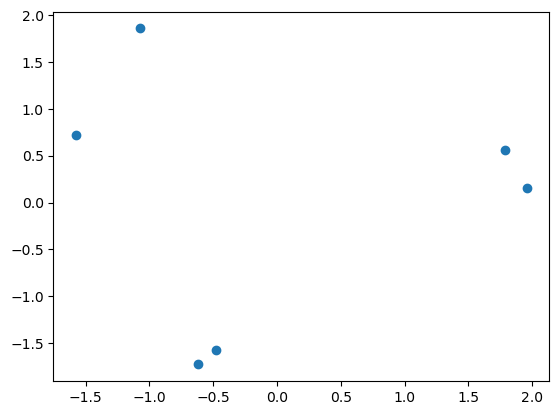

In [13]:
visualize_latent_space(latents)

In [14]:
import numpy as np

def visualize_latent_space_distribution(latent_primitives):
    # Reshape the latent primitives to be 2D
    latent_primitives = latent_primitives.reshape(-1, latent_primitives.shape[-1])

    # Perform PCA on the latent primitives
    pca = PCA(n_components=2)
    reduced_latents = pca.fit_transform(latent_primitives)

    # Create a 2D histogram
    heatmap, xedges, yedges = np.histogram2d(reduced_latents[:, 0], reduced_latents[:, 1], bins=50)
    
    # Plot the 2D histogram
    plt.imshow(heatmap.T, origin='lower')
    plt.show()


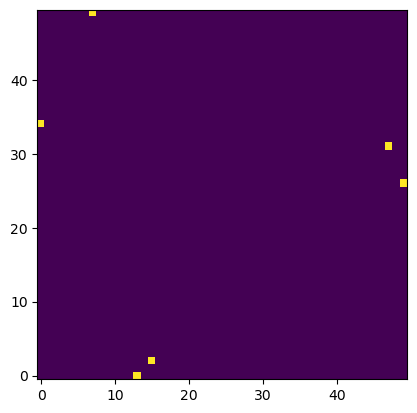

In [15]:
visualize_latent_space_distribution(latents)

In [16]:
from sklearn.manifold import TSNE

def plot_tsne(latent_primitives):
    # Flatten the batch and sequence dimension
    latent_primitives_flattened = latent_primitives.reshape(-1, latent_primitives.shape[-1])

    # Apply t-SNE
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(latent_primitives_flattened)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.show()


In [17]:
dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
batch = next(iter(dataloader))
poses, timestamps = batch["poses"], batch["timestamps"]
poses.shape, timestamps.shape

NameError: name 'DataLoader' is not defined

In [ ]:
out = model.encoder(poses=poses, timestamps=timestamps)
latent_primitives = out["latent_primitives"].detach().numpy()

In [18]:
plot_tsne(latent_primitives)

NameError: name 'latent_primitives' is not defined